In [205]:
import arviz as az
import numpy as np
import pandas as pd
import pymc3 as pm
import seaborn as sns
import statistics as st
from quap import quap
from matplotlib import pylab as plt
from scipy import stats

In [206]:
RANDOM_SEED = 8927
np.random.seed(RANDOM_SEED)

%config InlineBackend.figure_format = 'retina'
%load_ext watermark
az.style.use("arviz-darkgrid")
az.rcParams["stats.hdi_prob"] = 0.89

# Chapter 4 - Linear models

### End of chapter problems

### 4E1.

In the model definition below, which line is the pdf of the data?

yi ∼ Normal(µ, σ)

µ ∼ Normal(0, 10)

σ ∼ Exponential(1)

The first line is the pdf of the data. Yi refers to the ith observation of the outcome variable Y.



### 4E2.
In the model definition just above, how many parameters are in the posterior distribution?

2, µ and σ

### 4E3.
Using the model definition above, write down the appropriate form of Bayes’ theorem that includes the proper pdf and priors

p(µ,σ|y)  ∝  Normal(µ, σ) * Normal(0, 10) * Exponential(1)

OR 

p(µ,σ|y)  =  Normal(µ, σ) * Normal(0, 10) * Exponential(1) / ∫ ∫ ( Normal(µ, σ) * Normal(0, 10) * Exponential(1)) dµdσ

### 4E4.
In the model definition below, which line is the linear model?

yi ∼ Normal(µ, σ)

µi = α + βxi

α ∼ Normal(0, 10)

β ∼ Normal(0, 1)

σ ∼ Exponential(2)

The second line is the linear decomposition of the parameter µ

### 4E5.
In the model definition just above, how many parameters are in the posterior distribution?

Three: α, β, and σ. The parameter µ has been decomposed into α and β.


### 4M1.
For the model definition below, simulate observed y values from the prior (not the posterior).

yi ∼ Normal(µ, σ)

µ ∼ Normal(0, 10)

σ ∼ Exponential(1)

(array([ 15.,  33.,  95., 177., 227., 221., 140.,  66.,  22.,   4.]),
 array([-28.9502723 , -22.99289364, -17.03551497, -11.07813631,
         -5.12075765,   0.83662102,   6.79399968,  12.75137834,
         18.70875701,  24.66613567,  30.62351433]),
 <BarContainer object of 10 artists>)

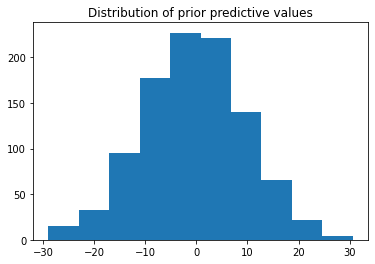

In [11]:
mu = np.random.normal(0, 10, size=1000)  # prior for mu
sigma = np.random.exponential(1, size=1000)  # prior for sigma
# get the samples from the likelihood
y = np.random.normal(mu, sigma)

plt.title("Distribution of prior predictive values")
plt.hist(y)


<AxesSubplot:>

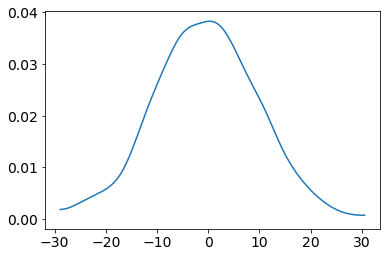

In [16]:
az.plot_kde(y)


### 4M4.

A sample of students is measured for height each year for 3 years. After the third year, you want to fit a linear regression predicting height using year as a predictor. Write down the mathematical
model definition for this regression, using any variable names and priors you choose. Be prepared to
defend your choice of priors.

Height_i ∼ Normal(µ, σ)

µi = α + β*Year_i

Year must be coded as 1,2,3 (not using actual year) or alpha will be uninterpretable.

α ∼ Normal(173, 20) 

α can be interpreted as the average height in year 1. I don't know anything abut this sample of students but I am 173 cm so this seems like a reasonable prior mean. A prior SD of 20 is very low information because it assigns high plausibility to α being anywhere between 133cm and 210cm.

β ∼ Normal(0, 20)

This is a low information prior, centered around 0 so I make no assumption about the sign of the slope, with a large SD (very improbable in reality that students are gaining 40 cm in height every year)

σ ∼ Exponential(10)

This is another low information prior, but Exponential because sigma cannot be negative.

### 4M5. 

Now suppose I remind you that every student got taller each year. Does this information lead
you to change your choice of priors? How?

I could change my prior for the slope to an exponential or a lognormal to not allow negative values of β

### 4M6.
Now suppose I tell you that the variance among heights for students of the same age is never
more than 64cm. How does this lead you to revise your priors?

I could change the prior for sigma to be Uniform(0,8)

### 4M7.

Refit model m4.3 from the chapter, but omit the mean weight xbar this time. Compare the
new model’s posterior to that of the original model. In particular, look at the covariance among the
parameters. What is different? Then compare the posterior predictions of both models.

In [207]:
# get the data for the adults
# load in the data
d = pd.read_csv("./../data/Howell1.csv", delimiter=";")
d2 = d[d.age >= 18]

In [210]:
# Original model 4.3
xbar = d2.weight.mean()
with pm.Model() as m4_3:
    a = pm.Normal("a", mu=178, sd=20)
    b = pm.Lognormal("b", mu=0, sd=1)
    sigma = pm.Uniform("sigma", 0, 50)
    mu = a + b * (d2.weight - xbar)
    height = pm.Normal("height", mu=mu, sd=sigma, observed=d2.height)
    idata,dist = quap(vars=[a,b,sigma],n_samples=10_000)
    samples = az.InferenceData.to_dataframe(idata)

In [211]:
az.summary(idata, kind="stats",hdi_prob=0.89)

,mean,sd,hdi_5.5%,hdi_94.5%
a,154.603,0.270,154.151,155.013
b,0.903,0.042,0.837,0.970
sigma,5.073,0.191,4.766,5.376


In [212]:
samples[["a","b","sigma"]].cov()

,a,b,sigma
a,0.072769,-0.000198,0.000191
b,-0.000198,0.001746,-0.000017
sigma,0.000191,-0.000017,0.036331


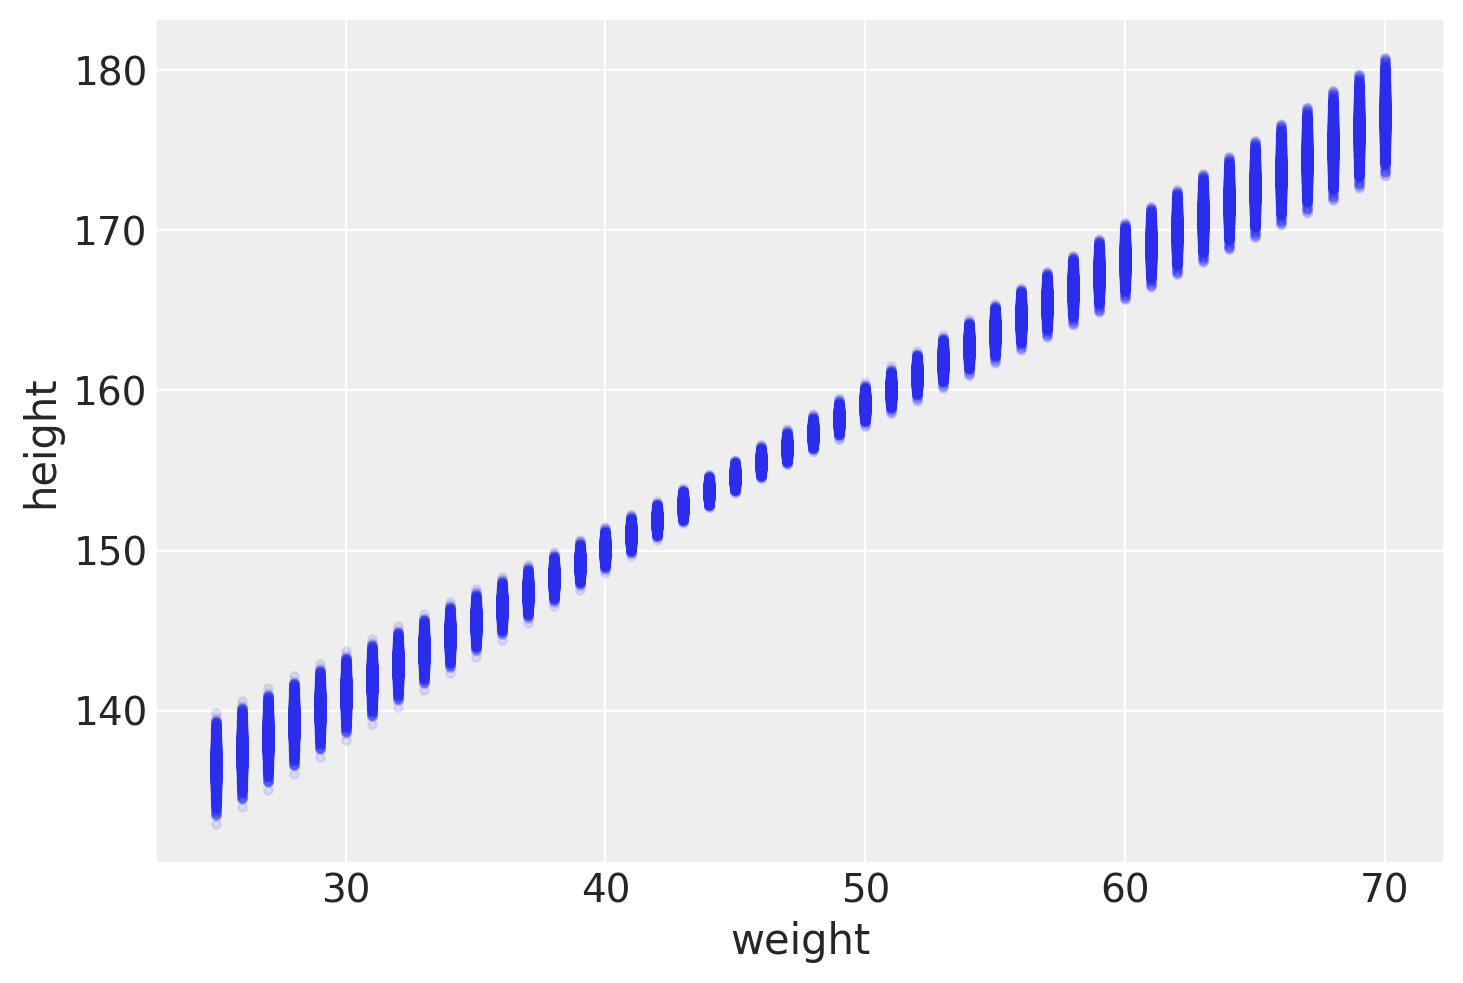

In [213]:
# Posterior predictions for 4.3
weight_seq = np.arange(25, 71)
mu_pred = np.zeros((len(weight_seq), len(samples)))
for i, w in enumerate(weight_seq):
    mu_pred[i] = samples["a"] + samples["b"] * (w - d2.weight.mean())
    
plt.plot(weight_seq, mu_pred, "C0.", alpha=0.1)
plt.xlabel("weight")
plt.ylabel("height");

In [209]:
### Rerun 4.3 without centering
with pm.Model() as m4_3_no_centering:
    a = pm.Normal("a", mu=178, sd=20)
    b = pm.Lognormal("b", mu=0, sd=1)
    sigma = pm.Uniform("sigma", 0, 50)
    mu = a + b * (d2.weight)
    height = pm.Normal("height", mu=mu, sd=sigma, observed=d2.height)
    idata2,dist = quap(vars=[a,b,sigma],n_samples=10_000)
    samples2 = az.InferenceData.to_dataframe(idata2)

In [214]:
az.summary(idata2, kind="stats",hdi_prob=0.89)

,mean,sd,hdi_5.5%,hdi_94.5%
a,114.515,1.918,111.369,117.481
b,0.891,0.042,0.827,0.962
sigma,5.076,0.190,4.776,5.384


In [215]:
samples2[["a","b","sigma"]].cov()

,a,b,sigma
a,3.677174,-0.080177,0.012408
b,-0.080177,0.001783,-0.000273
sigma,0.012408,-0.000273,0.036184


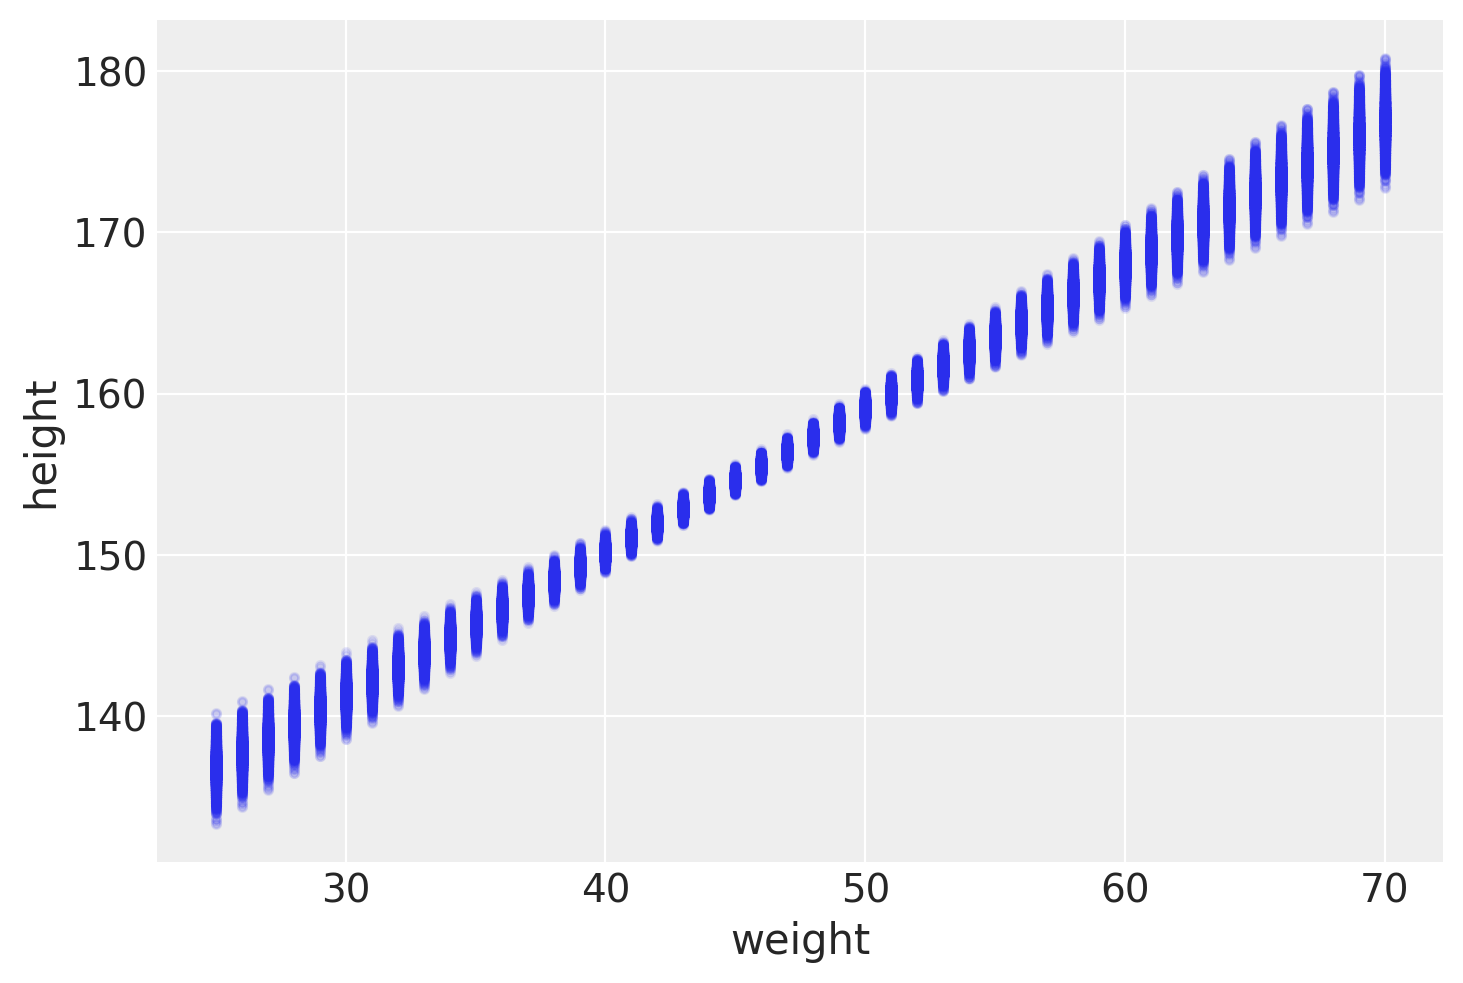

In [216]:
# Posterior predictions for 4.3_uncentered
weight_seq2 = np.arange(25, 71)
mu_pred2 = np.zeros((len(weight_seq), len(samples2)))
for i, w in enumerate(weight_seq):
    mu_pred2[i] = samples2["a"] + samples2["b"] * (w)
    
plt.plot(weight_seq2, mu_pred2, "C0.", alpha=0.1)
plt.xlabel("weight")
plt.ylabel("height");

The posterior predictions look the same, despite the fact that the predicted mean for α is lower, and the predicted standard deviation (uncertainty) for α is much higher.

This is because in the first case, α is the predicted value of height when weight-mean(weight) = 0, or when weight = mean(weight). In other words in the first model, the y-axis is at x = mean(weight) instead of x = 0.

Let's replot with the intercepts plotted:

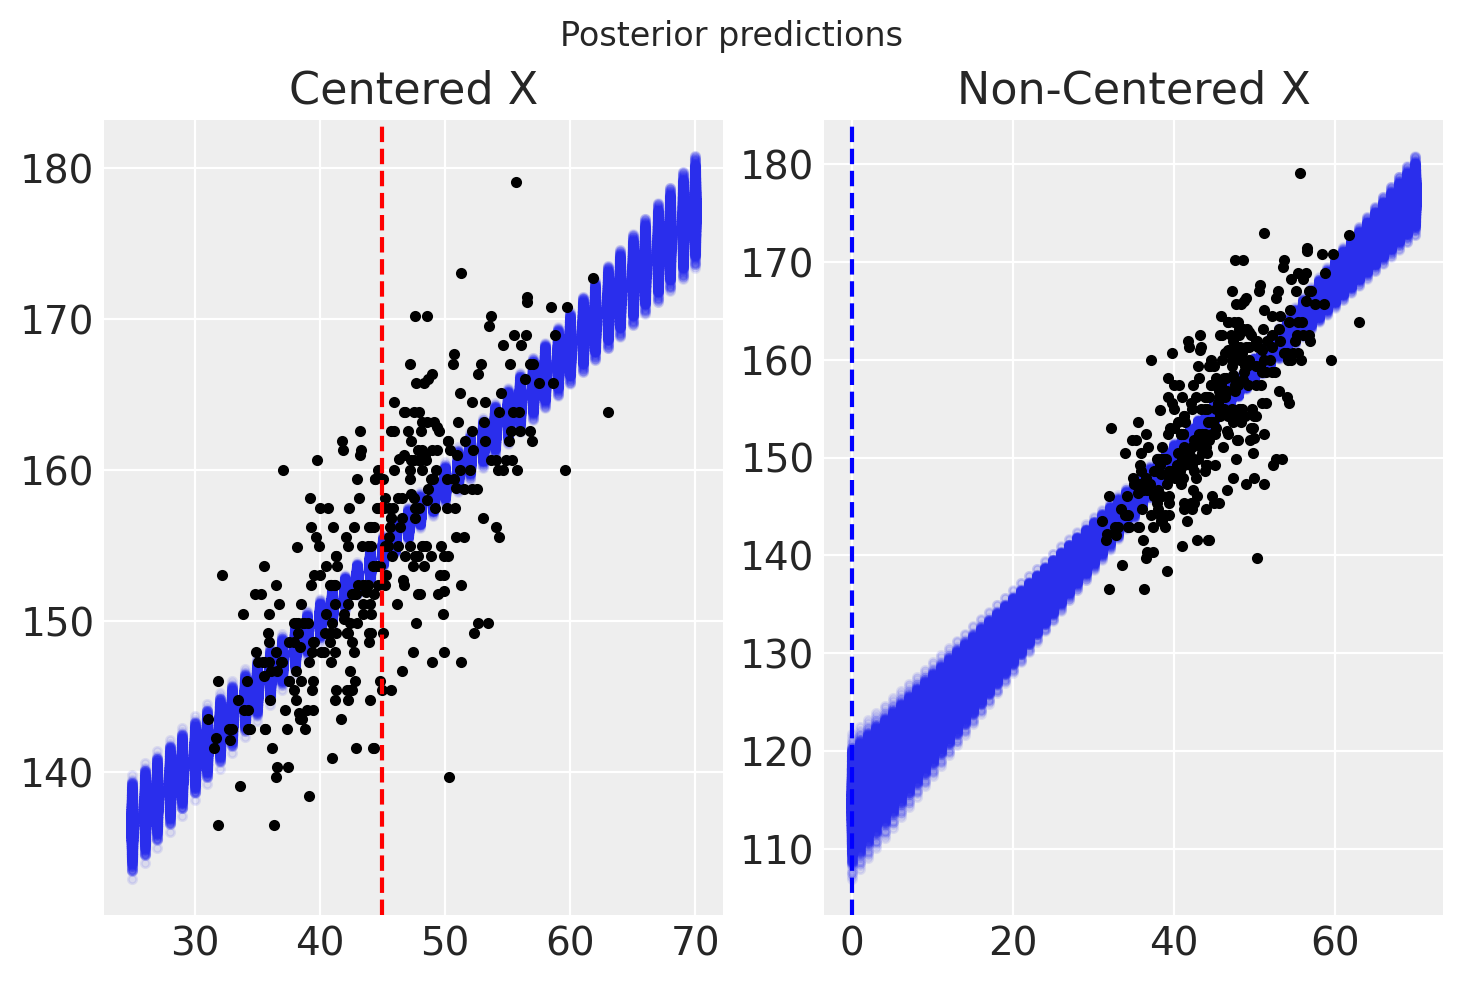

In [217]:
weight_seq2 = np.arange(0, 71)
mu_pred2 = np.zeros((len(weight_seq2), len(samples2)))
for i, w in enumerate(weight_seq2):
    mu_pred2[i] = samples2["a"] + samples2["b"] * (w)
    
fig, (ax1, ax2) = plt.subplots(1, 2)
fig.suptitle('Posterior predictions')
ax1.plot(weight_seq, mu_pred,"C0.", alpha=0.1)
ax1.plot(d2.weight, d2.height,".",c="k")
ax1.set_title("Centered X")
ax1.axvline(np.mean(d2.weight),ls="--", c="r", label="x = Mean weight")
ax2.plot(weight_seq2, mu_pred2,"C0.", alpha=0.1)
ax2.plot(d2.weight, d2.height,".",c="k")
ax2.set_title("Non-Centered X")
ax2.axvline(np.mean(0),ls="--", c="b", label="x = 0")

### 4H1.

The weights listed below were recorded in the !Kung census, but heights were not recorded for
these individuals. Provide predicted heights and 89% intervals for each of these individuals. That is,
fill in the table below, using model-based predictions.


| Individual | Weight | Expected height | 89% interval|
|------|------|-------|-----|
|   1  | 46.95|?|?|
|   2  | 43.72|?|?|
|   3  | 64.78|?|?|
|   4  | 32.59|?|?|
|   5  | 54.63|?|?|

In [220]:
weights = np.array([46.95,43.72,64.78,32.59,54.63])
expected_heights = samples2["a"].mean() + samples2["b"].mean()*weights
heights_lower = samples2["a"].quantile(0.055)+samples2["b"].quantile(0.055)*weights
heights_upper = samples2["a"].quantile(0.945)+samples2["b"].quantile(0.945)*weights
df = {'Weight':weights,'Expected height':expected_heights,'5.5% bound':heights_lower,'94.5% bound':heights_upper}
print(pd.DataFrame(df))

   Weight  Expected height  5.5% bound  94.5% bound
0   46.95       156.357972  150.142861   162.584407
1   43.72       153.479334  147.478820   159.485389
2   64.78       172.248408  164.848698   179.691370
3   32.59       143.560066  138.299013   148.806730
4   54.63       163.202535  156.477175   169.952970


### 4H2.

Select out all the rows in the Howell1 data with ages below 18 years of age. If you do it right,
you should end up with a new data frame with 192 rows in it.

(a) Fit a linear regression to these data. Present and interpret the estimates. For
every 10 units of increase in weight, how much taller does the model predict a child gets?

(b) Plot the raw data, with height on the vertical axis and weight on the horizontal axis. Superimpose the MAP regression line and 89% interval for the mean. Also superimpose the 89% interval
for predicted heights.

(c) What aspects of the model fit concern you? Describe the kinds of assumptions you would
change, if any, to improve the model. You don’t have to write any new code. Just explain what the
model appears to be doing a bad job of, and what you hypothesize would be a better model.



In [224]:
dchild = d[d.age < 18]
len(dchild)

192

In [225]:
### a)
xbar = dchild.weight.mean()
with pm.Model() as m4h2:
    a = pm.Normal("a", mu=120, sd=20)
    b = pm.Normal("b", mu=0, sd=30)
    sigma = pm.Uniform("sigma", 0, 50)
    mu = a + b * (dchild.weight-xbar)
    height = pm.Normal("height", mu=mu, sd=sigma, observed=dchild.height)
    idata,dist = quap(vars=[a,b,sigma],n_samples=10_000)
    samples = az.InferenceData.to_dataframe(idata)

In [226]:
az.summary(idata, kind="stats",hdi_prob=0.89)

,mean,sd,hdi_5.5%,hdi_94.5%
a,108.317,0.609,107.273,109.225
b,2.720,0.069,2.613,2.831
sigma,8.434,0.433,7.743,9.117


This model predicts that the average height of a child of average weight will be 108 cm, and that for 10kg increase in weight a child will be taller by 27cm.

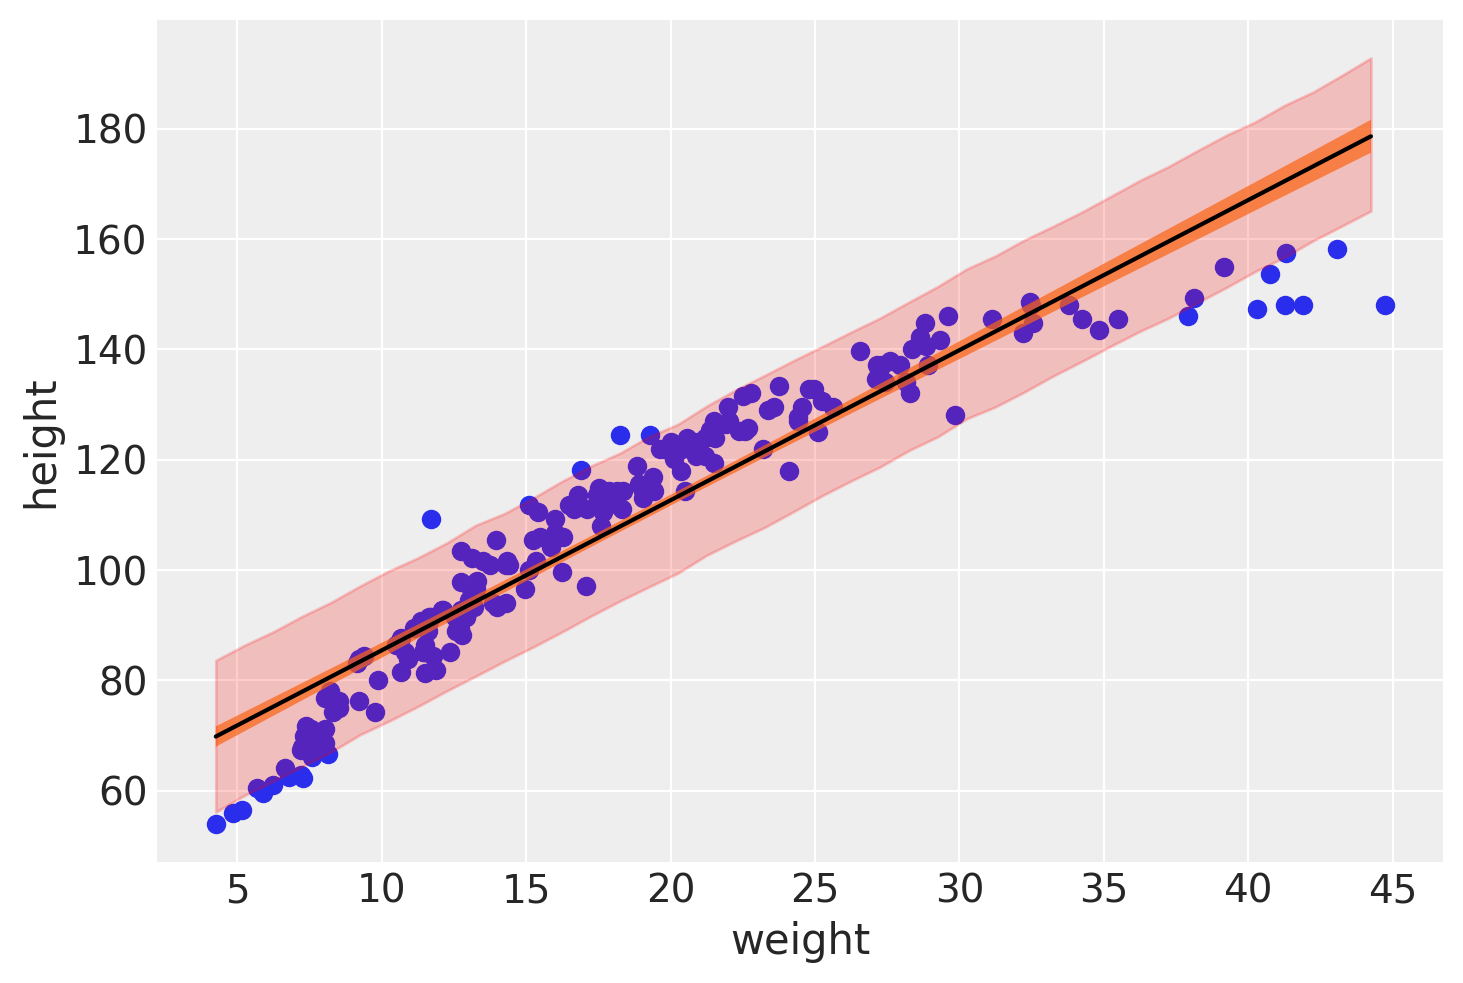

In [234]:
weight_seq = np.arange(dchild.weight.min(), dchild.weight.max())
mu_pred = np.zeros((len(weight_seq), len(samples)))
height_pred = np.zeros((len(weight_seq), len(samples)))
for i, w in enumerate(weight_seq):
    mu_pred[i] = samples["a"] + samples["b"] * (w - xbar)
    height_pred[i] = np.random.normal(mu_pred[i], samples["sigma"])

plt.scatter(dchild.weight, dchild.height)
plt.plot(weight_seq, mu_pred.mean(1), "k")
plt.fill_between(weight_seq, np.quantile(mu_pred,0.055,axis=1), np.quantile(mu_pred,0.945,axis=1), alpha=0.7)
plt.fill_between(weight_seq, np.quantile(height_pred,0.055,axis=1), np.quantile(height_pred,0.945,axis=1), alpha=0.2,color='red')
plt.xlabel("weight")
plt.ylabel("height")
plt.show()


We have fit a linear model to an apparently non-linear relationship. Some non-linear relationship may do better.

### 4H3.
Suppose a colleague of yours, who works on allometry, glances at the practice problems just
above. Your colleague exclaims, “That’s silly. Everyone knows that it’s only the logarithm of body
weight that scales with height!” Let’s take your colleague’s advice and see what happens.

(a) Model the relationship between height (cm) and the natural logarithm of weight (log-kg). Use
the entire Howell1 data frame, all 544 rows, adults and non-adults. Can you interpret the resulting
estimates?

(b) Begin with this plot: plot( height ~ weight , data=Howell1 ). Then use samples
from the quadratic approximate posterior of the model in (a) to superimpose on the plot: (1) the
predicted mean height as a function of weight, (2) the 97% interval for the mean, and (3) the 97%
interval for predicted heights

In [235]:
### a)
d["log_weight"] = np.log(d.weight)
d.head()

,height,weight,age,male,log_weight
0,151.765,47.825606,63.0,1,3.867561
1,139.700,36.485807,63.0,0,3.596923
2,136.525,31.864838,65.0,0,3.461503
3,156.845,53.041914,41.0,1,3.971082
4,145.415,41.276872,51.0,0,3.720302


In [236]:
with pm.Model() as m4h3:
    a = pm.Normal("a", mu=120, sd=20)
    b = pm.Normal("b", mu=0, sd=30)
    sigma = pm.Uniform("sigma", 0, 50)
    mu = a + b * (d.log_weight)
    height = pm.Normal("height", mu=mu, sd=sigma, observed=d.height)
    idata,dist = quap(vars=[a,b,sigma],n_samples=10_000)
    samples = az.InferenceData.to_dataframe(idata)

In [237]:
az.summary(idata, kind="stats",hdi_prob=0.89)

,mean,sd,hdi_5.5%,hdi_94.5%
a,-23.164,1.338,-25.196,-20.918
b,46.900,0.383,46.251,47.483
sigma,5.136,0.158,4.883,5.384


the intercept can be interpreted as: the predicted height when the log of the weight is equal to 0 (i.e when weight=1). This is obviously not a real prediction and the model can't really be interpreted for weights of less than ~5.

The b can be interpreted as: for every increase in a log-kg of weight, heights are predicted to increase by 46 cm. In other words, every time weights multiply by .71 (natural rate o

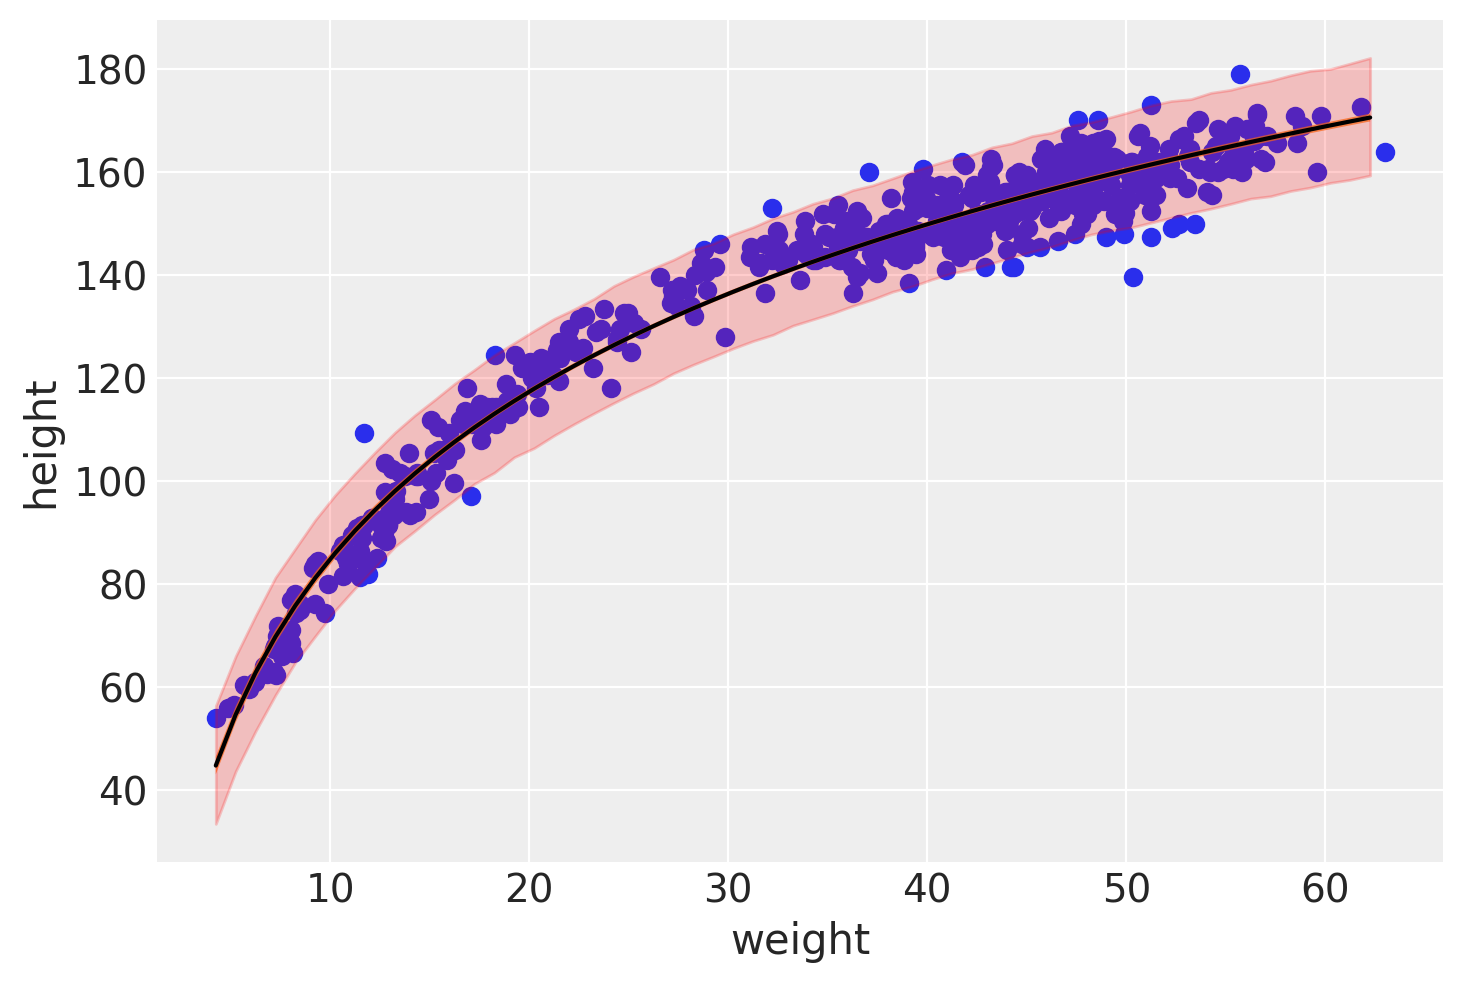

In [239]:
weight_seq = np.arange(d.weight.min(), d.weight.max())

mu_pred = np.zeros((len(weight_seq), len(samples)))
height_pred = np.zeros((len(weight_seq), len(samples)))
for i, w in enumerate(weight_seq):
    mu_pred[i] = samples["a"] + samples["b"] * (np.log(w))
    height_pred[i] = np.random.normal(mu_pred[i], samples["sigma"])

plt.scatter(d.weight, d.height)
plt.plot(weight_seq, mu_pred.mean(1), "k")
plt.fill_between(weight_seq, np.quantile(mu_pred,0.015,axis=1), np.quantile(mu_pred,0.985,axis=1), alpha=0.7)
plt.fill_between(weight_seq, np.quantile(height_pred,0.015,axis=1), np.quantile(height_pred,0.985,axis=1), alpha=0.2,color='red')
plt.xlabel("weight")
plt.ylabel("height")
plt.show()


106.83732697976502